# Fitting formulae accuracy

To test the accuracy of the Taylor expansion, we need to fit the measured moments by some analytical function. To check the accuracy of the fit, we generate Gaussian or ST models with the fitted moments, and compare how these reproduce the multipoles against the full measured model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from streaming.models.measured import Measured
from streaming.models import stream
import copy

In [2]:
import matplotlib.font_manager
import matplotlib as mpl
mpl.style.use('~/StreamingModel/streaming/utils/mplstyle')

In [3]:
pdf_filename = "../data/pairwise_velocity_pdf.hdf5"
tpcf_filename = "../data/tpcf.hdf5"

simulation = Measured(pdf_filename, tpcf_filename)

gaussian = stream.Stream(simulation, 'gaussian')


## Best fit to the mean

In [4]:
def m_10_fit(r,  a, b, c):
    
    return -a * np.exp(-b * r) + c

popt_m_10, pcov = curve_fit(m_10_fit,
            simulation.r[15:100], simulation.m_10.mean(simulation.r[15:100]))

/cosma/local/pythonconda3/4.5.4/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5,0,'r [Mpc/h]')

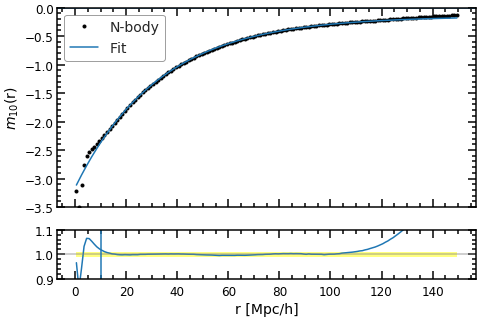

In [5]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.plot(simulation.r, simulation.m_10.mean(simulation.r), marker = 'o',
        markersize = 3, linestyle ='', color ='k', label = 'N-body')

ax1.plot(simulation.r, m_10_fit(simulation.r, *popt_m_10), label = 'Fit')

ax1.axhline(y = 0.)
ax1.legend()
ax1.set_ylim(-3.5, 0)


ax2.plot(simulation.r,
         m_10_fit(simulation.r, *popt_m_10)/simulation.m_10.mean(simulation.r))


#plt.xlim(5,100)
ax2.fill_between(simulation.r, 0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.axhline(y = 1., linestyle='-', color='gray', alpha = 0.5)
ax2.set_ylim(0.9,1.1)
ax2.axvline(x = 10)

ax1.set_ylabel('$m_{10}$(r)')
ax2.set_xlabel('r [Mpc/h]')

## Best fits to radial and tangential c_2

In [6]:
def c_20_fit(r, a, b, c):
    
    return - a * np.exp(-b * r) + c

popt_c_20, pcov = curve_fit(c_20_fit, simulation.r[5:60],
            simulation.c_20.mean(simulation.r[5:60]),  p0 = (3., 0.01,0))


Text(0.5,0,'r [Mpc/h]')

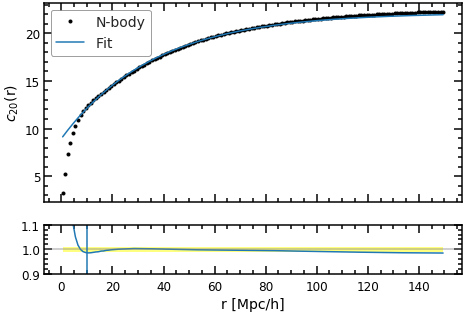

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.plot(simulation.r, simulation.c_20.mean(simulation.r), marker = 'o',
        markersize = 3, linestyle ='', color ='k', label = 'N-body')

ax1.plot(simulation.r, c_20_fit(simulation.r, *popt_c_20), label = 'Fit')

ax1.legend()


ax2.plot(simulation.r,
         c_20_fit(simulation.r, *popt_c_20)/simulation.c_20.mean(simulation.r))


ax2.fill_between(simulation.r, 0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.axhline(y = 1., linestyle='-', color='gray', alpha = 0.5)
ax2.set_ylim(0.9,1.1)
ax2.axvline(x = 10)

ax1.set_ylabel('$c_{20}$(r)')
ax2.set_xlabel('r [Mpc/h]')

In [8]:
def c_02_fit(r, a, b, c):
    
    return a * r**c + b

popt_c_02, pcov = curve_fit(c_02_fit, simulation.r[5:60],
            simulation.c_02.mean(simulation.r[5:60]))

Text(0.5,0,'r [Mpc/h]')

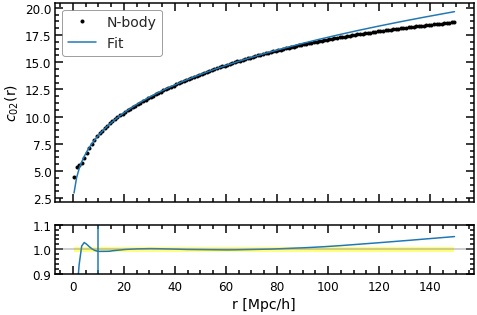

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.plot(simulation.r, simulation.c_02.mean(simulation.r), marker = 'o',
        markersize = 3, linestyle ='', color ='k', label = 'N-body')

ax1.plot(simulation.r, c_02_fit(simulation.r, *popt_c_02), label = 'Fit')

ax1.legend()


ax2.plot(simulation.r,
         c_02_fit(simulation.r, *popt_c_02)/simulation.c_02.mean(simulation.r))


ax2.fill_between(simulation.r, 0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.axhline(y = 1., linestyle='-', color='gray', alpha = 0.5)
ax2.set_ylim(0.9,1.1)
ax2.axvline(x = 10)

ax1.set_ylabel('$c_{02}$(r)')
ax2.set_xlabel('r [Mpc/h]')

## Test accuracy of fitting formulae by replacing the measured moments for the fitted ones in the Gaussian Streaming Model, one at a time

In [10]:
best_fit_moments = {
            'm_10': {'function': m_10_fit, 'popt': popt_m_10},
            'c_20': {'function': c_20_fit, 'popt': popt_c_20},
            'c_02': {'function': c_02_fit, 'popt': popt_c_02},
        }

measured_moments = {
            'm_10': {'function': simulation.m_10.mean, 'popt': ()},
            'c_20': {'function': simulation.c_20.mean, 'popt': ()},
            'c_02': {'function': simulation.c_02.mean, 'popt': ()},
        }

In [11]:
reduced_models = []

for key in best_fit_moments:
    # copy all measured moments
    moments = copy.deepcopy(measured_moments)
    # subtitute for fitted one at a time
    moments[key] = best_fit_moments[key]
    
    gaussian_reduced = stream.Stream(simulation, 'gaussian',
                        best_fit_moments = moments)
    
    reduced_models.append(gaussian_reduced)

In [12]:
# Using all fitted moments:
gaussian_reduced = stream.Stream(simulation, 'gaussian',
                        best_fit_moments = best_fit_moments)

In [14]:
colors = ['forestgreen', 'orange', 'purple']

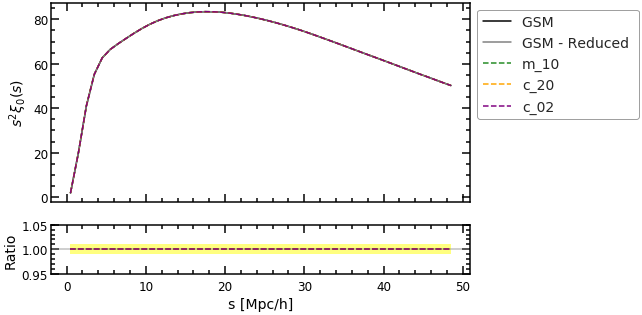

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.plot(gaussian_reduced.s_c, 
         gaussian_reduced.s_c **2* gaussian.monopole, 
         label = 'GSM ', color='black')

ax1.plot(gaussian_reduced.s_c, 
         gaussian_reduced.s_c **2 * gaussian_reduced.monopole, 
         label = 'GSM - Reduced ', color='gray')

for i, key in enumerate(best_fit_moments):

    ax1.plot(reduced_models[i].s_c, reduced_models[i].s_c**2 * reduced_models[i].monopole, 
         linestyle='dashed', color = colors[i],
         label = key)

ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.axhline(y = 1., linestyle='-', color='gray', alpha = 0.5)

ax2.plot(gaussian.s_c,  gaussian_reduced.monopole/gaussian.monopole, 
         linestyle='dashed', color = 'black')

for i, key in enumerate(best_fit_moments):

    ax2.plot(reduced_models[i].s_c,  reduced_models[i].monopole/gaussian.monopole, 
         linestyle='dashed', color = colors[i],
         label = key)

    
ax1.set_ylabel(r'$s^2 \xi_0 (s)$')
ax2.set_xlabel(r's [Mpc/h]')
ax2.set_ylabel(r'Ratio')

ax2.set_ylim(0.95,1.05)
#ax1.set_ylim(-5.,25)

ax1.legend(bbox_to_anchor=(1,1))

(0.95, 1.05)

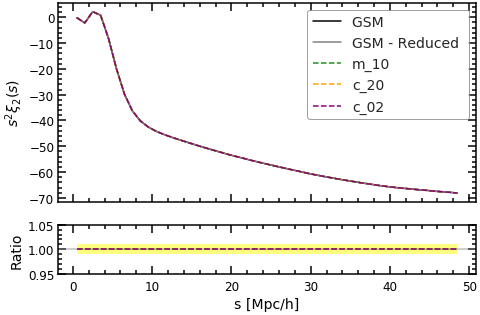

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.plot(gaussian_reduced.s_c, 
         gaussian_reduced.s_c **2* gaussian.quadrupole, 
         label = 'GSM ', color='black')

ax1.plot(gaussian_reduced.s_c, 
         gaussian_reduced.s_c **2 * gaussian_reduced.quadrupole, 
         label = 'GSM - Reduced ', color='gray')

for i, key in enumerate(best_fit_moments):

    ax1.plot(reduced_models[i].s_c, reduced_models[i].s_c**2 * reduced_models[i].quadrupole, 
         linestyle='dashed', color = colors[i],
         label = key)

ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.axhline(y = 1., linestyle='-', color='gray', alpha = 0.5)

ax2.plot(gaussian.s_c,  gaussian_reduced.quadrupole/gaussian.quadrupole, 
         linestyle='dashed', color = 'black')

for i, key in enumerate(best_fit_moments):

    ax2.plot(reduced_models[i].s_c,  reduced_models[i].quadrupole/gaussian.quadrupole, 
         linestyle='dashed', color = colors[i],
         label = key)

    
ax1.set_ylabel(r'$s^2 \xi_2 (s)$')
ax2.set_xlabel(r's [Mpc/h]')
ax2.set_ylabel(r'Ratio')

ax1.legend(bbox_to_anchor=(1,1))
ax2.set_ylim(0.95,1.05)



(0.95, 1.05)

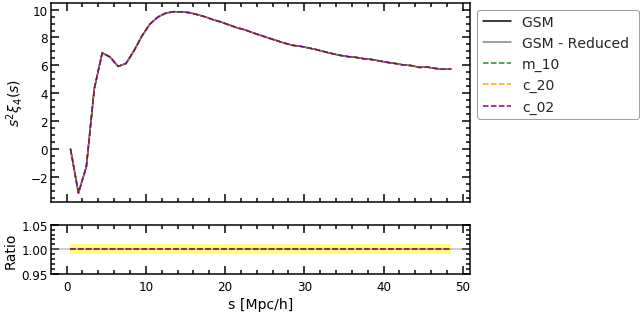

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.plot(gaussian_reduced.s_c, 
         gaussian_reduced.s_c **2* gaussian.hexadecapole, 
         label = 'GSM ', color='black')

ax1.plot(gaussian_reduced.s_c, 
         gaussian_reduced.s_c **2 * gaussian_reduced.hexadecapole, 
         label = 'GSM - Reduced ', color='gray')

for i, key in enumerate(best_fit_moments):

    ax1.plot(reduced_models[i].s_c, reduced_models[i].s_c**2 * reduced_models[i].hexadecapole, 
         linestyle='dashed', color = colors[i],
         label = key)

ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.axhline(y = 1., linestyle='-', color='gray', alpha = 0.5)

ax2.plot(gaussian.s_c,  gaussian_reduced.hexadecapole/gaussian.hexadecapole, 
         linestyle='dashed', color = 'black')

for i, key in enumerate(best_fit_moments):
    ax2.plot(reduced_models[i].s_c,  reduced_models[i].hexadecapole/gaussian.hexadecapole, 
         linestyle='dashed', color = colors[i],
         label = key)

    
ax1.set_ylabel(r'$s^2 \xi_4 (s)$')
ax2.set_xlabel(r's [Mpc/h]')
ax2.set_ylabel(r'Ratio')

ax1.legend(bbox_to_anchor=(1,1))
ax2.set_ylim(0.95,1.05)
